In [1]:
%matplotlib inline
import os
import sys
import glob
import pickle

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf


from gpflow.config import default_float

import tensorflow_probability as tfp

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

2022-12-20 11:54:31.389758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 11:54:31.555280: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-20 11:54:31.562785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 11:54:31.562802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [3]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')



new_tract_shapefile = os.path.join(data_dir,'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')

In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [5]:
mass_gdf = gpd.read_file(new_tract_shapefile)


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf
missing_squares = [square for square in deaths_gdf['grid_squar'].unique() if square not in mass_gdf['GEOID'].unique()]
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]

# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors
    
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1
        
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [6]:
import pickle
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/poi_fix_soft/ind200_kernelsvi_full_lr0.05_seed2/model.mod','rb') as f:
    m = pickle.load(f)


2022-12-20 11:59:18.107834: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-20 11:59:18.107895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2022-12-20 11:59:18.107910: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p1cmp078.pax.tufts.edu
2022-12-20 11:59:18.108108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-12-20 11:59:18.108159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-12-20 11:59:18.108168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-12-20 11:59:18.108996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

In [7]:
pd.read_csv('/cluster/tufts/hugheslab/kheuto01/opioid/logs/poi_fix_soft/ind200_kernelsvi_full_lr0.05_seed2/stats.csv')

,Unnamed: 0,iter,elbo,mae,bpr_100
0,0,0.0,-89387.300229,1.846895,0.105228
1,1,10.0,-56140.572387,1.633227,0.071115
2,2,20.0,-51832.008532,1.061007,0.096381
3,3,30.0,-50223.321168,0.819931,0.074593
4,4,40.0,-49276.777737,0.660522,0.080084
...,...,...,...,...,...
195,195,1950.0,-45723.575517,0.340907,0.316468
196,196,1960.0,-45707.846191,0.344207,0.305418
197,197,1970.0,-45724.375148,0.347187,0.324804
198,198,1980.0,-45748.266944,0.342356,0.312880


In [8]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

In [9]:
fold='test'
maes = []
xtop = []
for quarter in range(1, 4 + 1):
    x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == 2019) & (
                deaths_gdf_with_autoregressive['quarter'] == quarter)][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
         'svi_pctile', 'neighbor_t-1', 'self_t-1']]
    y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == 2019) & (
                deaths_gdf_with_autoregressive['quarter'] == quarter)][['grid_squar', 'timestep', 'deaths']]
    _, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x.loc[:,
                                                              ['lat', 'lon', 'timestep', 'theme_1_pc',
                                                               'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                                                               'svi_pctile', 'neighbor_t-1',
                                                               'self_t-1']].values)
    sg_2019 = tf.math.softplus(fmean * normcdf(gmean) + 2).numpy()
    pred_2019_df = pd.Series(sg_2019.squeeze(), index=y.grid_squar)

    maes.append(mean_absolute_error(y.deaths, pred_2019_df))
    xtop.append(fixed_top_X(y.set_index('grid_squar')['deaths'], pred_2019_df, 100)[-1])

print(f'MAE {fold} {np.mean(maes)}')
print(f'BPR-100 {fold} {np.mean(xtop)}')

MAE test 0.34360763608148787
BPR-100 test 0.31876700440941924


In [10]:
fold='test'
maes = []
xtop = []
for quarter in range(1, 4 + 1):
    x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == 2019) & (
                deaths_gdf_with_autoregressive['quarter'] == quarter)][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
         'svi_pctile', 'neighbor_t-1', 'self_t-1']]
    y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == 2019) & (
                deaths_gdf_with_autoregressive['quarter'] == quarter)][['grid_squar', 'timestep', 'deaths']]
    _, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x.loc[:,
                                                              ['lat', 'lon', 'timestep', 'theme_1_pc',
                                                               'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                                                               'svi_pctile', 'neighbor_t-1',
                                                               'self_t-1']].values)
       

In [43]:
fold='train'
maes = []
xtop = []
likelihoods = []
for year in range(2000,2018):
    for quarter in range(1, 4 + 1):
        x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == year) & (
                    deaths_gdf_with_autoregressive['quarter'] == quarter)][
            ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
             'svi_pctile', 'neighbor_t-1', 'self_t-1']]
        y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == year) & (
                    deaths_gdf_with_autoregressive['quarter'] == quarter)][['grid_squar', 'timestep', 'deaths']]
        _, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x.loc[:,
                                                                  ['lat', 'lon', 'timestep', 'theme_1_pc',
                                                                   'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                                                                   'svi_pctile', 'neighbor_t-1',
                                                                   'self_t-1']].values)
        
        data_shape = fmean.shape
        u = tf.random.normal(shape=data_shape + (1000,), dtype=default_float())
        w = tf.random.normal(shape=data_shape + (1000,), dtype=default_float())

        # Expand dims to give the mean a sample dimension
        g_mean_NDS = tf.expand_dims(gmean, -1)
        g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
        g_samples = g_mean_NDS + u * g_std_NDS
        del u
        phi_g_samples = normcdf(g_samples)
        del g_samples

        f_mean_NDS = tf.expand_dims(fmean, -1)
        f_var_NDS = tf.expand_dims(fvar, -1)
        f_std_NDS = tf.math.sqrt(f_var_NDS)
        f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

        shifted_softplus_f_samples = tf.math.softplus(f_samples+2)
        del f_samples

        y_poi = tfp.distributions.Poisson(rate=shifted_softplus_f_samples,
                                          force_probs_to_zero_outside_support=True)
        y_NDS = tf.expand_dims(tf.expand_dims(tf.cast(y['deaths'],dtype=default_float()),-1),-1)
        y_is_zero = tf.cast(y_NDS==0, default_float())
        py_if_zero = (1-phi_g_samples) + phi_g_samples*y_poi.prob(y_NDS)
        py_if_greater = phi_g_samples*y_poi.prob(y_NDS)
        py = y_is_zero*py_if_zero + (1-y_is_zero)*py_if_greater

        likelihoods.append(np.mean(np.mean(py,-1)))
        
        sg_2019 = tf.math.softplus(fmean * normcdf(gmean) + 2).numpy()
        pred_2019_df = pd.Series(sg_2019.squeeze(), index=y.grid_squar)

        maes.append(mean_absolute_error(y.deaths, pred_2019_df))
        xtop.append(fixed_top_X(y.set_index('grid_squar')['deaths'], pred_2019_df, 100)[-1])
        
print(f'MAE {fold} {np.mean(maes)}')
print(f'BPR-100 {fold} {np.mean(xtop)}')
print(f'Likelihood {fold} {np.mean(likelihoods)}')

MAE train 0.2067282469294778
BPR-100 train 0.2229348508994106
Likelihood train 0.8157534738195406


In [14]:
fold='test'
maes = []
xtop = []
likelihoods = []
for year in range(2019,2020):
    for quarter in range(1, 4 + 1):
        x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == year) & (
                    deaths_gdf_with_autoregressive['quarter'] == quarter)][
            ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
             'svi_pctile', 'neighbor_t-1', 'self_t-1']]
        y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year'] == year) & (
                    deaths_gdf_with_autoregressive['quarter'] == quarter)][['grid_squar', 'timestep', 'deaths']]
        _, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x.loc[:,
                                                                  ['lat', 'lon', 'timestep', 'theme_1_pc',
                                                                   'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                                                                   'svi_pctile', 'neighbor_t-1',
                                                                   'self_t-1']].values)
        
        data_shape = fmean.shape
        u = tf.random.normal(shape=data_shape + (1000,), dtype=default_float())
        w = tf.random.normal(shape=data_shape + (1000,), dtype=default_float())

        # Expand dims to give the mean a sample dimension
        g_mean_NDS = tf.expand_dims(gmean, -1)
        g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
        g_samples = g_mean_NDS + u * g_std_NDS
        del u
        phi_g_samples = normcdf(g_samples)
        del g_samples

        f_mean_NDS = tf.expand_dims(fmean, -1)
        f_var_NDS = tf.expand_dims(fvar, -1)
        f_std_NDS = tf.math.sqrt(f_var_NDS)
        f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

        shifted_softplus_f_samples = tf.math.softplus(f_samples+2)
        del f_samples

        y_poi = tfp.distributions.Poisson(rate=shifted_softplus_f_samples,
                                          force_probs_to_zero_outside_support=True)
        y_NDS = tf.expand_dims(tf.expand_dims(tf.cast(y['deaths'],dtype=default_float()),-1),-1)
        y_is_zero = tf.cast(y_NDS==0, default_float())
        py_if_zero = (1-phi_g_samples) + phi_g_samples*y_poi.prob(y_NDS)
        py_if_greater = phi_g_samples*y_poi.prob(y_NDS)
        py = y_is_zero*py_if_zero + (1-y_is_zero)*py_if_greater

        likelihoods.append(np.mean(np.mean(py,-1)))
        
        sg_2019 = tf.math.softplus(fmean * normcdf(gmean) + 2).numpy()
        pred_2019_df = pd.Series(sg_2019.squeeze(), index=y.grid_squar)

        maes.append(mean_absolute_error(y.deaths, pred_2019_df))
        xtop.append(fixed_top_X(y.set_index('grid_squar')['deaths'], pred_2019_df, 100)[-1])
        
print(f'MAE {fold} {np.mean(maes)}')
print(f'BPR-100 {fold} {np.mean(xtop)}')
print(f'Likelihood {fold} {np.mean(likelihoods)}')

MAE test 0.34360763608148787
BPR-100 test 0.31876700440941924
Likelihood test 0.7018913444098649


In [49]:
tfp.distributions.Poisson(rate=0.12).prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.88692045>

In [138]:
norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(x_just_2019.iloc[:,1:])
fold='test'
norm_cdf_upper_bound = y_just_2019['deaths'].values+0.5
norm_cdf_lower_bound = y_just_2019['deaths'].values-0.5
norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0

print(f'Likelihood {fold}: {np.mean(norm_likelihood_upper-norm_likelihood_lower)}')
print(f"MAE {fold} {mean_absolute_error(y_just_2019['deaths'].values, norm_mean)}")

Likelihood test: 0.9220026908663563
MAE test 0.38921212018495843


In [11]:
bprs=[]
for quarter in range(1,5):
    xq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    yq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]

    
    norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(xq.iloc[:,1:])
    fold='test'
    norm_cdf_upper_bound = yq['deaths'].values+0.5
    norm_cdf_lower_bound = yq['deaths'].values-0.5
    norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
    norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
    norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0
    
    bpr = fixed_top_X(yq.set_index(['grid_squar'])['deaths'], pd.Series(norm_mean.squeeze(), index=x_just_2019q1.grid_squar), X=100)[-1]
    bprs.append(bpr)
    
print(f'Test bpr-100: {np.mean(bprs)}')

AttributeError: 'DataFrame' object has no attribute 'dtype'

0.3448142414860681

In [159]:
pd.__version__

'1.1.5'

In [89]:
import scipy

In [21]:
gpflow

<module 'gpflow' from '/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/gpflow/__init__.py'>

In [22]:
gpflow.__version__

'0.4.0'

In [61]:
def normcdf(x, mean, std_dev):
    return 0.5 * (1.0 + tf.math.erf((x-mean) / (std_dev*np.sqrt(2.0)))) 

In [40]:
.shape

(123120, 8)

In [126]:
x_just_2019

,grid_squar,lat,lon,timestep,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,neighbor_t-1,self_t-1
76,25001010100,42.059829,-70.200407,76.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
77,25001010100,42.059829,-70.200407,77.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
78,25001010100,42.059829,-70.200407,78.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
79,25001010100,42.059829,-70.200407,79.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,1.0
164,25001010206,41.922636,-70.015368,76.0,0.6196,0.5629,0.0957,0.5658,0.5244,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
142463,25027761401,42.489753,-71.579677,79.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.333333,0.0
142548,25027761402,42.531342,-71.592751,76.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.250000,0.0
142549,25027761402,42.531342,-71.592751,77.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.125000,0.0
142550,25027761402,42.531342,-71.592751,78.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.500000,0.0


In [77]:
phi_g_samples.numpy().mean()

0.9492438688236642

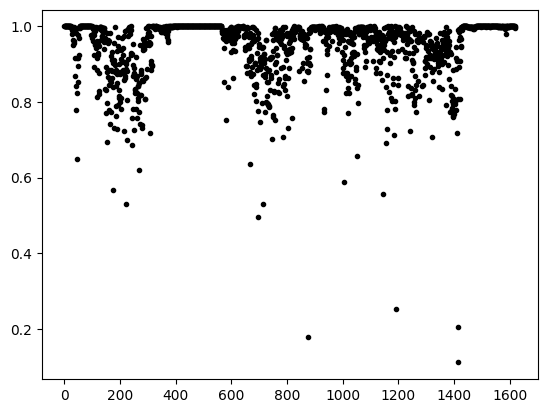

In [79]:
plt.plot(phi_g_samples.numpy().mean(-1),'k.')

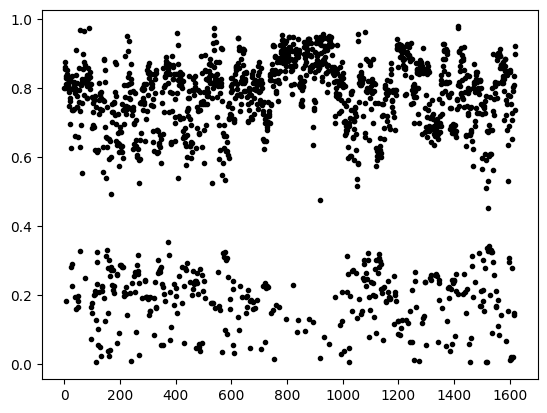

In [44]:
plt.plot(py.numpy().mean(-1),'k.')

In [41]:
y[py.numpy().mean(-1)<0.4]['deaths'].mean()

1.1932367149758454

In [48]:
y_poi

<tfp.distributions.Poisson 'Poisson' batch_shape=[1620, 1, 1000] event_shape=[] dtype=float64>

In [50]:
likelihoods

[0.9041401388936627,
 0.9070702118924374,
 0.8950933009603039,
 0.904184030566403,
 0.8900226309151863,
 0.879015727751145,
 0.8978723243521708,
 0.8721729367214,
 0.8666357322423973,
 0.8733013992934966,
 0.8845725835801617,
 0.8728991564542715,
 0.846677803922801,
 0.8402057423555533,
 0.8512017427581932,
 0.8573155400666108,
 0.8834652736764046,
 0.8837128707788023,
 0.8776145579022728,
 0.8581779734902262,
 0.871416292949756,
 0.8527773895444528,
 0.8604908774208015,
 0.8609469541135103,
 0.8561743389324775,
 0.8562374471548267,
 0.8312141958195834,
 0.8405955969192547,
 0.8199788325269818,
 0.8448128404845341,
 0.8627626818731521,
 0.8618728992084238,
 0.8483068157104608,
 0.846696633605539,
 0.8523957086140945,
 0.8490644538113516,
 0.8456741707860809,
 0.8641955603357527,
 0.8419094447306672,
 0.8454763340655703,
 0.8484384654429662,
 0.8764927822021157,
 0.8727964912564302,
 0.8562253205050955,
 0.8437258668572738,
 0.8613454969401367,
 0.8451097625540656,
 0.8203251370941256,
